In [2]:
import os
import numpy as np
import pandas as pd
import json
import yaml
from sklearn.model_selection import train_test_split
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import shutil
from operator import is_not
from functools import partial
from PIL import Image
from ultralytics import YOLO
from IPython.display import display, Image
from IPython import display
display.clear_output()
!yolo checks
HOME = os.getcwd()

Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
Setup complete ✅ (72 CPUs, 250.5 GB RAM, 421.4/1876.2 GB disk)

OS                  Linux-5.15.0-113-generic-x86_64-with-glibc2.29
Environment         Linux
Python              3.8.10
Install             git
RAM                 250.54 GB
CPU                 Intel Xeon Gold 5220 2.20GHz
CUDA                12.1

numpy               ✅ 1.24.4<2.0.0,>=1.23.0
matplotlib          ✅ 3.7.5>=3.3.0
opencv-python       ✅ 4.8.0.74>=4.6.0
pillow              ✅ 10.2.0>=7.1.2
pyyaml              ✅ 6.0.1>=5.3.1
requests            ✅ 2.31.0>=2.23.0
scipy               ✅ 1.10.1>=1.4.1
torch               ✅ 2.2.1>=1.8.0
torchvision         ✅ 0.17.1>=0.9.0
tqdm                ✅ 4.66.2>=4.64.0
psutil              ✅ 5.9.8
py-cpuinfo          ✅ 9.0.0
pandas              ✅ 2.0.3>=1.1.4
seaborn             ✅ 0.13.2>=0.11.0
ultralytics-thop    ✅ 2.0.0>=2.0.0


In [11]:
#!pip install -U ultralytics

Package                  Version              Location                                                   
------------------------ -------------------- -----------------------------------------------------------
absl-py                  2.1.0                
aiosignal                1.3.1                
apturl                   0.5.2                
attrs                    19.3.0               
backcall                 0.1.0                
bcrypt                   3.1.7                
bleach                   3.1.1                
blinker                  1.4                  
Brlapi                   0.7.0                
cachetools               5.4.0                
certifi                  2023.7.22            
chardet                  4.0.0                
charset-normalizer       3.3.2                
Click                    7.0                  
colorama                 0.4.3                
command-not-found        0.3                  
contourpy                1.1.1      

In [19]:
import numpy as np

# Exemple de tableau de forme (10, 256, 256, 3)
Y = np.random.random((10, 256, 256, 3))

# Sélection de l'élément
i = 0
result = Y[i, ..., 2]

print(result.shape)  # (256, 256)


(256, 256)


In [14]:
np.expand_dims(x, axis=0)
x.shape

(2,)

In [21]:
#!pip install opencv-python==4.8.0.74
#?tune.uniform()
HOME

'/home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data'

## Install YOLOv8

In [ ]:
def get_image_mask_pairs(data_dir):
    """
    retrieve image and mask from a given directory
    """
    image_paths = []
    mask_paths = []
    
    for root, _, files in os.walk(data_dir):
        if 'images' in root:
            for file in files:
                if file.endswith('.png'):
                    image_paths.append(os.path.join(root, file))
                    #print(f'{root}\n, {files}') 
                    mask_paths.append(os.path.join(root.replace('images', 'masks'), file.replace("img", "masks")))
                      
    return image_paths, mask_paths

def mask_to_polygons(mask):

    """
        Draw contours arround the mask 
    """

    # Find the contour of an object precisely the coordonnates of the boundary shape
    # Use RETR_TREE retrievial hierachy mode 
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        if len(contour) > 2:
            poly = contour.reshape(-1).tolist()
            if len(poly) > 4:  # Ensure valid polygon
                polygons.append(poly)
    return polygons

def process_data(image_paths, mask_paths, output_dir):

    """
    
    """
    annotations = []
    images = []
    image_id = 0
    ann_id = 0
    
    for img_path, mask_path in zip(image_paths, mask_paths):
        image_id += 1
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED) #return the loaded image as is (with alpha channel, otherwise it gets cropped).
        
        # Copy image to output directory
        shutil.copy(img_path, os.path.join(output_dir, os.path.basename(img_path)))
        
        images.append({
            "id": image_id,
            "file_name": os.path.basename(img_path),
            "height": img.shape[0],
            "width": img.shape[1]
        })
        
        unique_values = np.unique(mask)
        for value in unique_values:
            if value == 0:  # Ignore background
                continue
            
            object_mask = (mask == value).astype(np.uint8) * 255
            polygons = mask_to_polygons(object_mask)
            
            for poly in polygons:
                ann_id += 1
                annotations.append({
                    "id": ann_id,
                    "image_id": image_id,
                    "category_id": 1,  # Only one category: Cellular
                    "segmentation": [poly],
                    "area": cv2.contourArea(np.array(poly).reshape(-1, 2)),
                    "bbox": list(cv2.boundingRect(np.array(poly).reshape(-1, 2))),
                    "iscrowd": 0
                })
    
        coco_output = {
            "images": images,
            "annotations": annotations,
            "categories": [{"id": 1, "name": "Cellular"}]
        }
        
        with open(os.path.join(output_dir, 'coco_annotations.json'), 'w') as f:
            json.dump(coco_output, f)


In [ ]:

data_dir = HOME
output_dir = 'COCO_output'
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')

# Create output directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

image_paths, mask_paths = get_image_mask_pairs(data_dir)

# Split data into train and val
train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

# Process train and val data
process_data(train_img_paths, train_mask_paths, train_dir)
process_data(val_img_paths, val_mask_paths, val_dir)

In [ ]:
def display_images_with_coco_annotations(image_paths:str, annotations:str, display_type='both'):
    """
    Lay out the images with the COCO annotations
    Params:
    ------
         Image_paths: the paths where the converted COCO.json has been stored
         annotations: path to anotations files
         display_both: Lay out annotated images along side the original image

    """
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    
    for ax, img_path in zip(axs.ravel(), image_paths):
        # Load image using OpenCV and convert it from BGR to RGB color space
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ax.imshow(image)
        ax.axis('off')  # Turn off the axes

        # Get image filename to match with annotations
        img_filename = os.path.basename(img_path)
        img_id = next(item for item in annotations['images'] if item["file_name"] == img_filename)['id']
        
        # Filter annotations for the current image
        img_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == img_id]
        
        # Generate random colors for each annotation
        colors = [tuple(np.random.rand(3)) for _ in img_annotations]

        for ann, color in zip(img_annotations, colors):
            # Display bounding box
            if display_type in ['bbox', 'both']:
                bbox = ann['bbox']
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], 
                                         linewidth=1, edgecolor=color, 
                                         facecolor='none')
                #ax.add_patch(rect)
            
            # Display segmentation polygon
            if display_type in ['seg', 'both']:
                for seg in ann['segmentation']:
                    poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                    polygon = patches.Polygon(poly, closed=True, edgecolor=color, 
                                              fill=False)
                    ax.add_patch(polygon)

    plt.tight_layout()
    plt.show()



In [ ]:
# Load COCO annotations
with open('COCO_output/train/coco_annotations.json', 'r') as f:
    annotations = json.load(f)

# Get all image files
image_dir = "COCO_output/train/"
all_image_files = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]

#Get some image at random
random_image_files = random.sample(all_image_files, 4)

# Choose between 'bbox', 'seg', or 'both'
display_type = 'seg'
display_images_with_coco_annotations(random_image_files, annotations, display_type)

In [2]:
import yaml

In [ ]:
"""
This code transforms a dataset of images and annotations into a format suitable 
for training a YOLO (You Only Look Once) object detection model, and it also 
creates a YAML configuration file required for training the model.

It reads coco style json annotations supplied as a single json file and also 
images as input. 

Here are the key steps in the code:

1. Convert Images to YOLO Format: The convert_to_yolo function takes paths for 
input images and annotations (in JSON format), and directories to store the 
output images and labels. It then performs the following operations:

- Reads the input JSON file containing annotations.
- Copies all PNG images from the input directory to the output directory.
- Normalizes the polygon segmentation data related to each image and writes 
them to text files, mapping them to the appropriate category .
- The resulting text files contain information about the object category and the normalized coordinates of the polygons that describe the objects.

2. Create YAML Configuration File: The create_yaml function takes paths to the input JSON file containing categories, training, validation, and optional test paths. It then:

- Extracts the category names and the number of classes.
- Constructs a dictionary containing information about class names, the number 
of classes, and paths to the training, validation, and test datasets.
- Writes this dictionary to a YAML file, which can be used as a configuration 
file for training a model (e.g., a YOLO model).
    


The text annotation file consists of lines representing individual object 
annotations, with each line containing the class ID followed by the normalized 
coordinates of the polygon describing the object.

Example structure of the YOLO annotation file:

<class_id> <normalized_polygon_coordinate_1> <normalized_polygon_coordinate_2> ... <normalized_polygon_coordinate_n>
0 0.123456 0.234567 0.345678 0.456789 ...

"""



# Function to convert images to YOLO format
def convert_to_yolo(input_images_path, input_json_path, output_images_path, output_labels_path):
    # Open JSON file containing image annotations
    f = open(input_json_path)
    data = json.load(f)
    f.close()

    # Create directories for output images and labels
    os.makedirs(output_images_path, exist_ok=True)
    os.makedirs(output_labels_path, exist_ok=True)

    # List to store filenames
    file_names = []
    for filename in os.listdir(input_images_path):
        if filename.endswith(".png"):
            source = os.path.join(input_images_path, filename)
            destination = os.path.join(output_images_path, filename)
            shutil.copy(source, destination)
            file_names.append(filename)

    # Function to get image annotations
    def get_img_ann(image_id):
        return [ann for ann in data['annotations'] if ann['image_id'] == image_id]

    # Function to get image data
    def get_img(filename):
        return next((img for img in data['images'] if img['file_name'] == filename), None)

    # Iterate through filenames and process each image
    for filename in file_names:
        img = get_img(filename)
        img_id = img['id']
        img_w = img['width']
        img_h = img['height']
        img_ann = get_img_ann(img_id)

        # Write normalized polygon data to a text file
        if img_ann:
            with open(os.path.join(output_labels_path, f"{os.path.splitext(filename)[0]}.txt"), "a") as file_object:
                for ann in img_ann:
                    current_category = ann['category_id'] - 1
                    polygon = ann['segmentation'][0]
                    normalized_polygon = [format(coord / img_w if i % 2 == 0 else coord / img_h, '.6f') for i, coord in enumerate(polygon)]
                    file_object.write(f"{current_category} " + " ".join(normalized_polygon) + "\n")

# Function to create a YAML file for the dataset
def create_yaml(input_json_path, output_yaml_path, train_path, val_path, test_path=None):
    with open(input_json_path) as f:
        data = json.load(f)
    
    # Extract the category names
    names = [category['name'] for category in data['categories']]
    
    # Number of classes
    nc = len(names)

    # Create a dictionary with the required content
    yaml_data = {
        'names': names,
        'nc': nc,
        'test': test_path if test_path else '',
        'train': train_path,
        'val': val_path
    }

    # Write the dictionary to a YAML file
    with open(output_yaml_path, 'w') as file:
        yaml.dump(yaml_data, file, default_flow_style=False)




### Test

In [ ]:
base_input_path = "COCO_output/"
base_output_path = "yolo_dataset/"

In [ ]:
print(os.path.join(base_input_path, "val1"))

In [ ]:
from ultralytics.data.converter import convert_coco

#Processing validation dataert
#convert_coco(labels_dir=os.path.join(base_input_path, "val"),
 #            save_dir=os.path.join(base_output_path, "valid_yolo"),
  #           use_keypoints=True)

In [ ]:
# Processing validation dataset (if needed)
convert_to_yolo(
    input_images_path=os.path.join(base_input_path, "val"),
    input_json_path=os.path.join(base_input_path, "val/coco_annotations.json"),
    output_images_path=os.path.join(base_output_path, "valid/images"),
    output_labels_path=os.path.join(base_output_path, "valid/labels")
)

In [ ]:
# Processing training dataset 
convert_to_yolo(
    input_images_path=os.path.join(base_input_path, "train"),
    input_json_path=os.path.join(base_input_path, "train/coco_annotations.json"),
    output_images_path=os.path.join(base_output_path, "train/images"),
    output_labels_path=os.path.join(base_output_path, "train/labels")
)

In [ ]:
# Creating the YAML configuration file
create_yaml(
    input_json_path=os.path.join(base_input_path, "train/coco_annotations.json"),
    output_yaml_path=os.path.join(base_output_path, "data.yaml"),
    train_path="train/images",
    val_path="valid/images",
    test_path='../test/images'  # or None if not applicable
)

### Visualize YOLO labels

In [ ]:
def display_images_with_annotations(image_paths, annotation_paths):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    
    for ax, img_path, ann_path in zip(axs.ravel(), image_paths, annotation_paths):
        # Load image using OpenCV and convert it from BGR to RGB color space
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_h, img_w, _ = image.shape
        
        ax.imshow(image)
        ax.axis('off')  # Turn off the axes

        # Open the annotation file and process each line
        with open(ann_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                category_id = int(parts[0])
                color = tuple(np.random.rand(3))  # Generate a random RGB color
                polygon = [float(coord) for coord in parts[1:]]
                polygon = [coord * img_w if i % 2 == 0 else coord * img_h for i, coord in enumerate(polygon)]
                polygon = [(polygon[i], polygon[i+1]) for i in range(0, len(polygon), 2)]
                patch = patches.Polygon(polygon, closed=True, edgecolor=color, fill=False)
                ax.add_patch(patch)

    plt.tight_layout()
    plt.show()

# Get all image files
image_dir = "yolo_dataset/train/images/"
annotation_dir = "yolo_dataset/train/labels/"
all_image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
random_image_files = random.sample(all_image_files, 4)

# Get corresponding annotation files
image_paths = [os.path.join(image_dir, f) for f in random_image_files]
annotation_paths = [os.path.join(annotation_dir, f.replace(".png", ".txt")) for f in random_image_files]

display_images_with_annotations(image_paths, annotation_paths)

In [7]:
import torch

state_dict = torch.load("from_phase2.pt", map_location='cuda:0')
print(state_dict.keys())


odict_keys(['encoder.patch_embed1.proj.weight', 'encoder.patch_embed1.proj.bias', 'encoder.patch_embed1.norm.weight', 'encoder.patch_embed1.norm.bias', 'encoder.patch_embed2.proj.weight', 'encoder.patch_embed2.proj.bias', 'encoder.patch_embed2.norm.weight', 'encoder.patch_embed2.norm.bias', 'encoder.patch_embed3.proj.weight', 'encoder.patch_embed3.proj.bias', 'encoder.patch_embed3.norm.weight', 'encoder.patch_embed3.norm.bias', 'encoder.patch_embed4.proj.weight', 'encoder.patch_embed4.proj.bias', 'encoder.patch_embed4.norm.weight', 'encoder.patch_embed4.norm.bias', 'encoder.block1.0.norm1.weight', 'encoder.block1.0.norm1.bias', 'encoder.block1.0.attn.q.weight', 'encoder.block1.0.attn.q.bias', 'encoder.block1.0.attn.kv.weight', 'encoder.block1.0.attn.kv.bias', 'encoder.block1.0.attn.proj.weight', 'encoder.block1.0.attn.proj.bias', 'encoder.block1.0.attn.sr.weight', 'encoder.block1.0.attn.sr.bias', 'encoder.block1.0.attn.norm.weight', 'encoder.block1.0.attn.norm.bias', 'encoder.block1.0.

In [20]:
state_dict = torch.load("yolov8l-seg.pt", map_location='cuda:0')
print(state_dict.keys())

dict_keys(['epoch', 'best_fitness', 'model', 'ema', 'updates', 'optimizer', 'train_args', 'date', 'version'])


### Training a model

In [1]:
import torch
import collections
from ultralytics import YOLO

# Load the YOLOv8 model architecture
model = YOLO("yolov8l-seg.yaml", task="segment")

# Load your custom weights
custom_weights = torch.load("from_phase2.pt", map_location='cuda:0')

# Convert OrderedDict to regular dict (if necessary)
if isinstance(custom_weights, collections.OrderedDict):
    custom_weights = dict(custom_weights)

# Load the custom weights into the model
model.model.load_state_dict(custom_weights, strict=False)

# Create a new checkpoint dictionary with the expected structure
new_checkpoint = {
    'model': model.model.state_dict(),  # Save the model state dictionary
    'epoch': 0,
    'best_fitness': None,
    'ema': None,
    'updates': None,
    'optimizer': None,
    'train_args': {},
    'date': None,
    'version': None
}

# Save the new checkpoint
torch.save(new_checkpoint, "adapted_weights.pt")

# Load the adapted weights into YOLOv8
model = YOLO("yolov8l-seg.yaml", task="segment")
model = YOLO("adapted_weights.pt", task="segment")

AttributeError: 'collections.OrderedDict' object has no attribute 'to'

In [10]:
import torch
import collections

# Load your custom weights
custom_weights = torch.load("from_phase2.pt", map_location='cuda:0')

# Convert OrderedDict to regular dict (if necessary)
if isinstance(custom_weights, collections.OrderedDict):
    custom_weights = dict(custom_weights)

# Create a new dictionary with the expected structure
new_checkpoint = {
    'model': custom_weights,  # Assuming your custom weights contain the model parameters
    'epoch': 0,
    'best_fitness': None,
    'ema': None,
    'updates': None,
    'optimizer': None,
    'train_args': {},
    'date': None,
    'version': None
}

# Save the new checkpoint
torch.save(new_checkpoint, "adapted_weights.pt")

# Load the adapted weights into YOLOv8
model = YOLO("yolov8l-seg.yaml", task="segment")
model = YOLO("adapted_weights.pt", task="segment")

AttributeError: 'dict' object has no attribute 'to'

In [2]:
HOME

'/home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data'

In [3]:
model = YOLO("yolov8l-seg.yaml", task="segment") # build a new model from yaml
model = YOLO("yolo_dataset/results/125m_epochs/weights/best.pt", task="segment") # MEDIAR fintuned_hase2 pre-trained weights

In [4]:
with open('yolo_dataset/data.yaml', 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

#### 100 epochs training

In [5]:
cellpose_projct = "yolo_dataset/results"
name = "125l_epochs_FocalLpsse"
#name = "small_200_size640_epochs"

In [7]:
# Tune hyperparameters on COCO8 for 30 epochs
#model.tune(data='yolo_dataset/data.yaml', epochs=100, iterations=300, optimizer='AdamW', plots=False, save=False, val=False)

In [6]:
# Train the model
results = model.train(data='yolo_dataset/data.yaml',
                    project=cellpose_projct,
                    name=name,
                    epochs=125
                    )
     

New https://pypi.org/project/ultralytics/8.2.86 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
engine/trainer: task=segment, mode=train, model=yolo_dataset/results/125m_epochs/weights/best.pt, data=yolo_dataset/data.yaml, epochs=125, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=yolo_dataset/results, name=125l_epochs_FocalLpsse, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_n

2024-09-02 10:33:02,771	INFO util.py:154 -- Outdated packages:
  ipywidgets==6.0.0 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-02 10:33:03,127	INFO util.py:154 -- Outdated packages:
  ipywidgets==6.0.0 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.



                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics.nn.modules.conv.Conv             [384

train: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/train/labels.cache... 432 images, 0 backgrounds, 0 corrupt: 100%|██████████| 432/432 [00:00<?, ?it/s]
val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]


Plotting labels to yolo_dataset/results/125l_epochs_FocalLpsse/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolo_dataset/results/125l_epochs_FocalLpsse
Starting training for 125 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/125      26.1G      1.253      1.802     0.5553      1.052       2150        640: 100%|██████████| 27/27 [00:38<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all        108      12091      0.872      0.771      0.831       0.51      0.869      0.752      0.815      0.453



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/125      21.2G      1.246      1.789     0.5728      1.055       3580        640: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        108      12091      0.869      0.771      0.826      0.503      0.863      0.759       0.81      0.455



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/125      27.7G      1.287      1.839     0.5889      1.061       3378        640: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

                   all        108      12091      0.864      0.771      0.826      0.489      0.867      0.753      0.813      0.449



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/125      22.8G      1.292      1.851     0.6024      1.064       2976        640: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all        108      12091      0.857      0.745      0.805      0.484       0.85      0.736       0.79      0.436



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/125      25.6G      1.261      1.845     0.6069      1.064       2921        640: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        108      12091      0.851       0.75      0.807      0.475      0.848      0.727      0.786      0.418



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/125      24.5G       1.32      1.917     0.6299      1.073       3250        640: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        108      12091      0.859      0.754      0.807      0.475      0.846      0.737      0.789      0.422



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/125      23.7G      1.286       1.87     0.6156      1.073       3253        640: 100%|██████████| 27/27 [00:24<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

                   all        108      12091      0.869      0.757      0.818      0.503      0.865      0.749      0.808       0.46



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/125      18.9G      1.285      1.865     0.6166      1.079       3110        640: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        108      12091      0.857      0.767      0.822      0.505      0.856      0.761      0.814      0.468



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/125      22.6G      1.317      1.893     0.6175      1.078       4003        640: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

                   all        108      12091      0.863      0.756      0.821      0.492      0.862      0.743      0.807      0.449



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/125      23.8G      1.329      1.876      0.622      1.074       4008        640: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        108      12091      0.862      0.751      0.809      0.493       0.86      0.734      0.793      0.441



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/125      26.3G      1.301      1.823     0.6072      1.069       2417        640: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        108      12091      0.878       0.75      0.822      0.504      0.877      0.736      0.809      0.455



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/125      25.5G      1.276      1.816     0.5991      1.062       3307        640: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        108      12091      0.868       0.76      0.821      0.495      0.867      0.741      0.805      0.443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/125      24.4G      1.272      1.833     0.5997      1.068       2726        640: 100%|██████████| 27/27 [00:22<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

                   all        108      12091      0.873      0.755      0.817      0.488      0.869       0.74      0.802      0.444



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/125      22.3G      1.301      1.862     0.6035      1.071       1997        640: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        108      12091      0.866      0.761      0.818      0.505      0.866      0.755      0.811      0.462



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/125      20.7G      1.308      1.865     0.6066      1.069       2861        640: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

                   all        108      12091      0.867      0.769      0.832      0.512      0.866      0.757      0.819      0.468



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/125      27.6G      1.294      1.852     0.5982      1.062       3090        640: 100%|██████████| 27/27 [00:24<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        108      12091      0.869      0.754       0.82      0.491      0.856       0.74      0.802      0.431



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/125      27.3G      1.252       1.79     0.5807      1.054       2332        640: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

                   all        108      12091      0.865       0.75      0.815      0.484      0.863      0.728      0.798      0.429



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/125      26.9G      1.285      1.811     0.5976      1.058       2597        640: 100%|██████████| 27/27 [00:22<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        108      12091       0.87      0.754      0.819      0.499      0.864      0.734      0.801      0.441



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/125      19.4G      1.289      1.807     0.5923      1.061       2764        640: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        108      12091      0.866       0.76      0.821      0.502      0.864      0.738      0.803      0.453



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/125      18.3G      1.263      1.798     0.5854      1.063       2465        640: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        108      12091      0.875      0.766      0.832      0.514      0.867      0.752      0.815      0.468



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/125      15.9G      1.261      1.801     0.5806      1.058       3462        640: 100%|██████████| 27/27 [00:22<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        108      12091      0.869      0.758      0.817      0.497      0.864      0.742      0.799      0.452



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/125      21.4G      1.265      1.809     0.5825      1.056       3673        640: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        108      12091      0.862      0.761      0.819      0.504      0.857      0.739      0.799      0.451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/125      23.4G      1.269      1.799     0.5846      1.057       3168        640: 100%|██████████| 27/27 [00:22<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

                   all        108      12091      0.868      0.758      0.821      0.501      0.864      0.739      0.803       0.45



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/125        24G      1.288      1.814     0.5887       1.07       3731        640: 100%|██████████| 27/27 [00:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        108      12091      0.873      0.767      0.826      0.502      0.864      0.746      0.808      0.449



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/125      24.2G       1.26      1.791     0.5794      1.055       3592        640: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        108      12091      0.873       0.77      0.833      0.503      0.873      0.755      0.821      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/125      21.3G      1.265      1.802     0.5816      1.052       3353        640: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        108      12091      0.862       0.75      0.811      0.484      0.858      0.731      0.797      0.438



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/125      23.8G      1.251      1.776     0.5755      1.049       3321        640: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

                   all        108      12091      0.862      0.753      0.814        0.5      0.856      0.736      0.798      0.448



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/125      25.4G      1.243      1.768     0.5789      1.044       3157        640: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        108      12091      0.858      0.768      0.819      0.499      0.855      0.756      0.808      0.457



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/125      22.8G      1.259      1.773     0.5816      1.054       2814        640: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

                   all        108      12091      0.867      0.759      0.824      0.497      0.866      0.742      0.807      0.451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/125      28.8G      1.257      1.794     0.5769      1.058       3980        640: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        108      12091      0.875      0.756      0.825      0.511       0.87      0.746      0.814      0.471



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/125        21G      1.247       1.79     0.5703      1.053       3453        640: 100%|██████████| 27/27 [00:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

                   all        108      12091      0.872      0.767      0.828      0.501      0.864      0.749      0.813      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/125      20.6G      1.238      1.757     0.5663      1.048       3261        640: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        108      12091      0.869      0.758      0.816      0.512      0.869      0.743      0.803      0.464



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/125      24.9G      1.256      1.768     0.5755      1.052       2001        640: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all        108      12091      0.866       0.77      0.826      0.508      0.862      0.754      0.812       0.47



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/125      26.4G      1.246      1.765     0.5693      1.055       3292        640: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all        108      12091      0.874      0.769      0.821      0.501      0.873      0.757       0.81      0.458



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/125      22.3G      1.251      1.767     0.5621      1.042       3362        640: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

                   all        108      12091      0.871      0.772      0.834      0.528      0.874      0.758      0.822      0.482



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/125        25G      1.237      1.751     0.5595      1.046       3779        640: 100%|██████████| 27/27 [00:23<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

                   all        108      12091      0.872      0.774       0.83       0.51      0.864      0.764      0.816       0.46



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/125      23.9G      1.232       1.74     0.5569      1.041       3204        640: 100%|██████████| 27/27 [00:22<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        108      12091      0.881      0.758      0.828      0.497      0.872      0.738      0.807      0.444



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/125      26.9G      1.239      1.748     0.5579      1.041       2920        640: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        108      12091      0.864      0.773      0.826      0.501      0.859      0.754      0.809      0.446



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/125      19.8G      1.247      1.765     0.5692      1.048       3007        640: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        108      12091      0.881      0.753       0.82      0.487      0.872      0.734        0.8      0.437



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/125      26.8G      1.214      1.718     0.5559      1.038       3759        640: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        108      12091      0.874      0.773      0.834      0.504      0.869      0.757      0.818      0.451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/125      24.4G      1.221      1.718     0.5549      1.046       2248        640: 100%|██████████| 27/27 [00:22<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

                   all        108      12091      0.864      0.767      0.824      0.486      0.862      0.745      0.807      0.424



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/125      24.9G       1.26      1.793     0.5687      1.042       3113        640: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        108      12091      0.879      0.765      0.824      0.504      0.877       0.75      0.814      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/125      23.6G      1.224      1.736     0.5603       1.04       2611        640: 100%|██████████| 27/27 [00:24<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        108      12091      0.878      0.755      0.824      0.498      0.868      0.739      0.808      0.448



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/125        22G      1.209       1.71     0.5492      1.035       2838        640: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        108      12091      0.876      0.756      0.821        0.5      0.869      0.746       0.81      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/125      25.5G      1.198       1.69     0.5417      1.035       2726        640: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all        108      12091      0.875      0.773      0.831       0.51      0.869       0.76      0.818      0.458



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/125      23.2G      1.193      1.683     0.5427       1.03       2640        640: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        108      12091      0.872      0.765      0.827      0.509       0.86      0.757      0.816      0.463



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/125      23.6G      1.221      1.719     0.5504      1.031       2968        640: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

                   all        108      12091      0.865      0.772      0.823      0.513      0.859      0.759       0.81      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/125      25.7G       1.23      1.741      0.559       1.05       2575        640: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        108      12091      0.875      0.767      0.827      0.518      0.871      0.752      0.815      0.479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/125      19.8G      1.226      1.718     0.5484      1.034       3429        640: 100%|██████████| 27/27 [00:24<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        108      12091       0.88      0.765      0.834      0.509      0.871      0.755      0.823      0.463



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/125      21.7G      1.201      1.699     0.5395       1.03       3313        640: 100%|██████████| 27/27 [00:24<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        108      12091      0.869      0.778      0.829      0.519      0.869       0.77      0.823      0.475



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/125      24.9G      1.188      1.684     0.5355      1.023       3066        640: 100%|██████████| 27/27 [00:24<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

                   all        108      12091      0.873      0.761      0.819      0.494      0.868      0.745      0.804      0.445



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/125      26.7G      1.197      1.683     0.5351      1.024       3001        640: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all        108      12091      0.867      0.766      0.827      0.513      0.871      0.751      0.815      0.468



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/125      21.1G      1.159      1.644     0.5252      1.025       2391        640: 100%|██████████| 27/27 [00:22<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all        108      12091      0.881      0.755      0.824      0.505      0.872      0.736      0.806      0.454



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/125        26G      1.179      1.664     0.5308      1.022       2719        640: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all        108      12091      0.871      0.762       0.82      0.501      0.862      0.741      0.801      0.452



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/125      23.8G      1.218      1.719     0.5413      1.029       2792        640: 100%|██████████| 27/27 [00:24<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        108      12091      0.876      0.772      0.826      0.522       0.88       0.76       0.82      0.483



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/125      26.5G      1.174       1.66     0.5291      1.028       2583        640: 100%|██████████| 27/27 [00:22<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        108      12091      0.874      0.759      0.822      0.512      0.869      0.748      0.811      0.474



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/125      23.6G      1.204      1.687     0.5357      1.029       2404        640: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        108      12091      0.878      0.771      0.832      0.519      0.873      0.758       0.82      0.475



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/125      21.4G      1.182      1.658     0.5267      1.019       2411        640: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        108      12091      0.873       0.77      0.827      0.512      0.868      0.756      0.814      0.464



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/125      22.9G      1.176      1.663     0.5252      1.017       2112        640: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        108      12091      0.873      0.776      0.828      0.521      0.869      0.762      0.818      0.476



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/125      21.8G      1.196      1.694     0.5339      1.027       3337        640: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

                   all        108      12091      0.872      0.764      0.821      0.513      0.871      0.752       0.81      0.471



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/125      23.3G      1.181      1.675     0.5291      1.014       2442        640: 100%|██████████| 27/27 [00:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

                   all        108      12091      0.866      0.776      0.829      0.507      0.866      0.758      0.818      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/125      23.8G      1.184      1.662     0.5307      1.019       3336        640: 100%|██████████| 27/27 [00:23<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

                   all        108      12091      0.879      0.765      0.828      0.505      0.874      0.753      0.816      0.461



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/125      24.2G      1.152      1.629     0.5176      1.014       2469        640: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        108      12091       0.88      0.758      0.816      0.504      0.871      0.746      0.803      0.462



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/125      24.5G      1.169      1.658     0.5214      1.015       3509        640: 100%|██████████| 27/27 [00:24<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

                   all        108      12091      0.874       0.76      0.821      0.501      0.869      0.741      0.806      0.458



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/125      26.3G      1.159      1.643     0.5162      1.015       2947        640: 100%|██████████| 27/27 [00:22<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        108      12091       0.88      0.767      0.828      0.509      0.875      0.752      0.815      0.461



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/125      23.3G      1.152      1.614     0.5116       1.01       3103        640: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        108      12091      0.875      0.774      0.827      0.506      0.871      0.767      0.817      0.457



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/125      21.3G      1.151      1.653     0.5124      1.009       3142        640: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        108      12091      0.871      0.777      0.834      0.512      0.863      0.763       0.82      0.462



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/125      24.9G      1.173      1.669     0.5143      1.007       3526        640: 100%|██████████| 27/27 [00:24<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

                   all        108      12091      0.873      0.776       0.83      0.505      0.869      0.761      0.816      0.456



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/125      20.3G      1.165      1.635     0.5134       1.02       3013        640: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        108      12091      0.878      0.774      0.833      0.518      0.874      0.762      0.822      0.473



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/125      18.1G      1.133      1.603     0.5007      1.007       3136        640: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        108      12091      0.866       0.78       0.83      0.517      0.864      0.766      0.819      0.471



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/125        27G      1.156      1.629     0.5066      1.005       5120        640: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        108      12091      0.873      0.773      0.828      0.515      0.872      0.755      0.817      0.471



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/125      27.6G      1.158      1.633     0.5082      1.005       3001        640: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        108      12091      0.877      0.773      0.825      0.499      0.872      0.757      0.811      0.453



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/125      24.1G       1.12      1.581     0.4999     0.9977       2922        640: 100%|██████████| 27/27 [00:24<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        108      12091      0.873      0.769      0.825      0.508      0.878       0.75      0.814      0.468



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/125      20.9G      1.157      1.639     0.5126      1.008       2987        640: 100%|██████████| 27/27 [00:22<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        108      12091      0.879      0.765      0.829      0.507      0.872       0.75      0.813      0.461



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/125      20.5G       1.15      1.625     0.5095      1.006       3085        640: 100%|██████████| 27/27 [00:22<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        108      12091      0.881      0.765      0.828      0.511      0.879       0.75      0.819      0.465



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/125      19.8G       1.16      1.643     0.5106      1.008       2496        640: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        108      12091      0.869      0.776      0.829      0.498      0.868      0.757      0.815       0.45



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/125      21.5G      1.139      1.626     0.5064      1.004       2596        640: 100%|██████████| 27/27 [00:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        108      12091      0.871      0.772      0.824      0.502      0.865      0.759      0.809      0.458



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/125      20.2G       1.13      1.612     0.4992      1.002       3196        640: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

                   all        108      12091      0.872      0.774      0.828      0.511      0.873      0.755      0.815       0.47



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/125      17.7G       1.12      1.588     0.4942      0.998       3070        640: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        108      12091      0.872      0.769      0.822      0.503      0.871      0.751       0.81      0.461



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/125      20.3G      1.122      1.578     0.4944     0.9923       2256        640: 100%|██████████| 27/27 [00:24<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        108      12091      0.882      0.763       0.83      0.518      0.875      0.748      0.816      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/125      29.4G      1.144      1.612     0.5021     0.9974       3802        640: 100%|██████████| 27/27 [00:24<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        108      12091      0.879      0.769       0.83      0.508      0.873      0.747      0.809      0.457



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/125      25.2G      1.117      1.578     0.4919      1.001       2933        640: 100%|██████████| 27/27 [00:23<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        108      12091      0.881      0.769      0.826      0.502      0.871      0.752       0.81      0.455



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/125      24.2G      1.135      1.599     0.4937     0.9987       3899        640: 100%|██████████| 27/27 [00:23<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        108      12091      0.878      0.771      0.831      0.504      0.871      0.758      0.818      0.458



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/125      23.4G      1.119      1.575     0.4886     0.9974       2836        640: 100%|██████████| 27/27 [00:23<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all        108      12091      0.884      0.767      0.832      0.516      0.875      0.753       0.82       0.47



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/125      27.1G      1.119      1.579     0.4899     0.9869       2514        640: 100%|██████████| 27/27 [00:23<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        108      12091      0.875      0.774      0.831      0.522      0.866      0.758      0.818      0.479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/125      26.7G       1.14      1.623     0.5001      0.993       3931        640: 100%|██████████| 27/27 [00:24<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        108      12091      0.876      0.768      0.832      0.517      0.873      0.746      0.816      0.471



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/125      19.1G      1.128      1.594     0.4949     0.9899       4013        640: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        108      12091      0.879      0.772       0.83      0.522      0.874       0.76      0.819      0.481



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/125      25.4G      1.114      1.567     0.4849     0.9883       4200        640: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        108      12091      0.877      0.773      0.832      0.514      0.874      0.761      0.823      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/125      23.3G      1.104      1.577      0.483      0.994       2251        640: 100%|██████████| 27/27 [00:23<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

                   all        108      12091      0.872      0.772      0.826      0.503      0.871      0.751       0.81      0.453



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/125      27.5G      1.099      1.552     0.4828      0.987       3148        640: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        108      12091      0.876       0.77      0.826      0.522      0.874      0.756      0.813      0.479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/125      23.3G      1.111      1.552     0.4815     0.9919       3359        640: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        108      12091      0.875      0.772      0.825      0.512      0.873      0.758      0.813      0.466



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/125      21.8G      1.095       1.54     0.4831     0.9875       2804        640: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        108      12091      0.874      0.771      0.832      0.522      0.876      0.757      0.821      0.478



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/125      24.8G      1.104       1.56      0.483     0.9882       2381        640: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        108      12091      0.878      0.776       0.83      0.507      0.874      0.759      0.815      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/125      26.6G       1.11      1.565     0.4833     0.9791       3329        640: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

                   all        108      12091      0.879      0.774      0.833      0.518      0.876      0.758       0.82      0.474



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/125      24.2G      1.129      1.595     0.4923     0.9897       3395        640: 100%|██████████| 27/27 [00:24<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        108      12091      0.883      0.766      0.832      0.519      0.877      0.758      0.822      0.477



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/125      20.4G      1.102      1.555     0.4828     0.9792       2878        640: 100%|██████████| 27/27 [00:24<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        108      12091      0.878       0.77      0.828      0.512      0.875      0.758      0.816      0.466



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/125      20.7G      1.094      1.549      0.481     0.9875       2243        640: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

                   all        108      12091      0.872      0.771      0.827      0.514      0.869      0.761      0.817      0.475



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/125      24.8G      1.084      1.528     0.4754     0.9862       2542        640: 100%|██████████| 27/27 [00:22<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        108      12091      0.876      0.768      0.829      0.523       0.87      0.756      0.817      0.477



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/125        24G      1.113      1.571     0.4844     0.9762       2395        640: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        108      12091      0.871      0.781      0.833      0.513      0.871       0.76      0.818      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/125      26.9G        1.1      1.557     0.4784     0.9769       4107        640: 100%|██████████| 27/27 [00:24<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

                   all        108      12091      0.883      0.765      0.832      0.517       0.88      0.752      0.819      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    101/125      25.6G      1.083      1.539     0.4755      0.979       3571        640: 100%|██████████| 27/27 [00:24<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

                   all        108      12091      0.869      0.775      0.825      0.506      0.867       0.76      0.812      0.464



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    102/125      31.4G      1.089      1.542     0.4737      0.975       3738        640: 100%|██████████| 27/27 [00:24<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        108      12091      0.877      0.774      0.833      0.516      0.875       0.76      0.822      0.475



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    103/125      21.8G      1.066      1.507     0.4646     0.9745       1958        640: 100%|██████████| 27/27 [00:23<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        108      12091      0.885       0.77      0.832      0.518      0.883      0.757      0.822      0.478



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    104/125      24.1G      1.081      1.539     0.4711     0.9792       1718        640: 100%|██████████| 27/27 [00:23<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        108      12091      0.885      0.763      0.827      0.504      0.878      0.748      0.812      0.457



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    105/125      22.6G      1.061      1.499     0.4617      0.975       3902        640: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

                   all        108      12091      0.881      0.766      0.823      0.508      0.876      0.753      0.811      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    106/125      29.5G      1.064      1.514     0.4654     0.9764       3815        640: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        108      12091      0.884      0.775      0.829      0.511      0.882      0.764      0.819      0.466



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    107/125      23.1G      1.081      1.535     0.4698     0.9772       2254        640: 100%|██████████| 27/27 [00:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

                   all        108      12091       0.88      0.772      0.829      0.515      0.879      0.761      0.818      0.478



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    108/125        28G      1.069      1.518     0.4691     0.9726       2565        640: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

                   all        108      12091       0.88      0.774      0.831      0.516      0.875      0.765       0.82      0.473



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    109/125      22.5G      1.047       1.49     0.4563     0.9693       3440        640: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

                   all        108      12091      0.878      0.776      0.832      0.521      0.872      0.765      0.822      0.477



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    110/125      16.5G      1.051      1.491     0.4595     0.9652       3018        640: 100%|██████████| 27/27 [00:23<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        108      12091      0.876      0.776       0.83      0.519      0.875      0.766      0.823       0.48



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    111/125      28.9G      1.051      1.491     0.4599     0.9676       2947        640: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        108      12091      0.879      0.768       0.83      0.512      0.881      0.752       0.82      0.467



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    112/125      21.7G      1.061      1.498     0.4606     0.9657       3033        640: 100%|██████████| 27/27 [00:24<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        108      12091      0.873      0.774      0.831       0.52      0.876      0.757      0.819      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    113/125        25G      1.038      1.472     0.4549      0.964       2329        640: 100%|██████████| 27/27 [00:23<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        108      12091       0.88      0.765      0.828      0.512      0.877       0.75      0.815       0.47



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    114/125      21.5G       1.03      1.462     0.4506     0.9688       2222        640: 100%|██████████| 27/27 [00:23<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all        108      12091      0.883      0.766      0.827      0.519      0.879      0.755      0.816      0.478



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    115/125      22.4G      1.042      1.474     0.4542     0.9683       3068        640: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        108      12091      0.881       0.77       0.83      0.516      0.875      0.757      0.819      0.469


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    116/125      18.9G      1.067      1.527     0.4661     0.9928       2524        640: 100%|██████████| 27/27 [00:32<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

                   all        108      12091      0.879      0.775      0.823      0.512      0.868      0.766      0.811      0.468



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    117/125      19.7G      1.049      1.494      0.453     0.9869       1974        640: 100%|██████████| 27/27 [00:20<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        108      12091      0.877      0.771      0.822      0.502      0.867      0.762      0.808      0.456



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    118/125      19.5G      1.055      1.493     0.4527     0.9796       1672        640: 100%|██████████| 27/27 [00:19<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

                   all        108      12091      0.873      0.774      0.821      0.506      0.879      0.751      0.807      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    119/125      23.4G       1.04      1.484     0.4477     0.9793       1530        640: 100%|██████████| 27/27 [00:19<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

                   all        108      12091      0.878      0.771      0.824       0.51      0.873      0.758      0.811      0.466



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    120/125      18.5G       1.03      1.466      0.443      0.973       1812        640: 100%|██████████| 27/27 [00:20<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]

                   all        108      12091      0.879      0.768      0.824      0.513      0.882      0.752      0.813      0.468



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    121/125      19.1G      1.032      1.465     0.4416     0.9778        878        640: 100%|██████████| 27/27 [00:19<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        108      12091      0.875      0.769      0.825      0.511      0.878      0.751      0.812      0.466



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    122/125      19.1G      1.027      1.458     0.4401     0.9723       1728        640: 100%|██████████| 27/27 [00:19<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        108      12091      0.875      0.771      0.826      0.513      0.876      0.754      0.813      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    123/125      20.1G      1.022      1.453     0.4375     0.9679       1576        640: 100%|██████████| 27/27 [00:19<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        108      12091      0.877      0.772      0.827      0.514      0.877      0.757      0.815      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    124/125        20G      1.024      1.458     0.4357     0.9759       1678        640: 100%|██████████| 27/27 [00:19<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        108      12091      0.878      0.772      0.828      0.514      0.872      0.761      0.817      0.468



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    125/125      18.1G      1.018       1.45     0.4331     0.9692       1860        640: 100%|██████████| 27/27 [00:20<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

                   all        108      12091      0.875      0.775      0.828      0.514       0.87      0.762      0.817       0.47



125 epochs completed in 0.987 hours.
Optimizer stripped from yolo_dataset/results/125l_epochs_FocalLpsse/weights/last.pt, 54.8MB
Optimizer stripped from yolo_dataset/results/125l_epochs_FocalLpsse/weights/best.pt, 54.8MB

Validating yolo_dataset/results/125l_epochs_FocalLpsse/weights/best.pt...
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.14s/it]


                   all        108      12091      0.871      0.772      0.834      0.528      0.873      0.758      0.821      0.482
Speed: 0.2ms preprocess, 10.4ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to yolo_dataset/results/125l_epochs_FocalLpsse


In [ ]:
#model = YOLO('yolo_dataset/results/125m_epochs/weights/best.pt')
#metrics= model.val(data='yolo_dataset/data.yaml', device=0, plots=True)
#metrics

In [ ]:
#j_idx = metrics.matrix[0][0]/metrics.matrix.sum()
#j_idx

In [7]:
def eval(model, data_dir, ious):

    #ious = np.linspace(.5,1,50)
    precision = []
    recall = []
    jac_idx = []
    for io in ious:
        tp_eval = YOLO(model)
        metrics = tp_eval.val(data= data_dir,
                              iou=io,
                              device=0
                              )
        precision.append(metrics.results_dict["metrics/precision(B)"])
        recall.append(metrics.results_dict["metrics/recall(B)"])
        conf_mtrx = metrics.confusion_matrix
        j_idx = conf_mtrx.matrix[0][0]/conf_mtrx.matrix.sum()
        jac_idx.append(j_idx)
    return jac_idx, precision, recall

In [ ]:
/home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/results/125l_epochs_FocalLpsse/weights/best.pt

In [8]:
jac_idx, precision, recall = eval(model="yolo_dataset/results/125l_epochs_FocalLpsse/weights/best.pt", data_dir="yolo_dataset/data.yaml", ious=np.linspace(.5,1,50))

Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:22<00:00,  3.18s/it]


                   all        108      12091      0.868      0.785      0.839      0.529      0.868      0.769      0.825      0.479
Speed: 0.8ms preprocess, 42.6ms inference, 0.1ms loss, 4.0ms postprocess per image
Results saved to runs/segment/val357
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:21<00:00,  3.05s/it]


                   all        108      12091      0.868      0.785      0.839      0.529      0.868      0.769      0.825      0.479
Speed: 0.3ms preprocess, 13.3ms inference, 0.0ms loss, 7.1ms postprocess per image
Results saved to runs/segment/val358
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:21<00:00,  3.01s/it]


                   all        108      12091      0.868      0.785      0.839      0.529      0.869      0.768      0.825      0.479
Speed: 2.1ms preprocess, 13.9ms inference, 0.0ms loss, 11.6ms postprocess per image
Results saved to runs/segment/val359
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:21<00:00,  3.00s/it]


                   all        108      12091      0.868      0.785      0.839      0.529      0.868      0.769      0.825      0.479
Speed: 2.2ms preprocess, 15.8ms inference, 0.0ms loss, 7.9ms postprocess per image
Results saved to runs/segment/val360
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:21<00:00,  3.11s/it]


                   all        108      12091      0.867      0.785      0.839      0.529      0.868      0.768      0.825      0.479
Speed: 0.3ms preprocess, 13.6ms inference, 0.0ms loss, 14.4ms postprocess per image
Results saved to runs/segment/val361
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:21<00:00,  3.03s/it]


                   all        108      12091      0.871      0.782      0.838      0.529      0.868      0.768      0.825      0.478
Speed: 0.2ms preprocess, 12.9ms inference, 0.0ms loss, 14.4ms postprocess per image
Results saved to runs/segment/val362
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:21<00:00,  3.10s/it]


                   all        108      12091      0.872       0.78      0.838      0.529      0.868      0.768      0.825      0.478
Speed: 0.3ms preprocess, 12.8ms inference, 0.0ms loss, 9.1ms postprocess per image
Results saved to runs/segment/val363
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:22<00:00,  3.18s/it]


                   all        108      12091      0.873      0.779      0.838      0.529      0.868      0.768      0.824      0.478
Speed: 0.3ms preprocess, 12.1ms inference, 0.0ms loss, 8.0ms postprocess per image
Results saved to runs/segment/val364
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:21<00:00,  3.05s/it]


                   all        108      12091      0.872      0.779      0.838      0.529      0.867      0.768      0.824      0.478
Speed: 0.3ms preprocess, 13.8ms inference, 0.0ms loss, 7.0ms postprocess per image
Results saved to runs/segment/val365
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.98s/it]


                   all        108      12091      0.872       0.78      0.838      0.529      0.869      0.765      0.824      0.478
Speed: 0.5ms preprocess, 15.0ms inference, 0.0ms loss, 12.9ms postprocess per image
Results saved to runs/segment/val366
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:21<00:00,  3.13s/it]


                   all        108      12091      0.871       0.78      0.837      0.529      0.869      0.765      0.824      0.478
Speed: 0.7ms preprocess, 11.5ms inference, 0.0ms loss, 8.5ms postprocess per image
Results saved to runs/segment/val367
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [02:16<00:00, 19.50s/it]


                   all        108      12091       0.87       0.78      0.837      0.529      0.868      0.765      0.824      0.478
Speed: 0.3ms preprocess, 11.9ms inference, 0.0ms loss, 7.8ms postprocess per image
Results saved to runs/segment/val368
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.88s/it]


                   all        108      12091       0.87      0.779      0.836      0.529      0.868      0.765      0.823      0.478
Speed: 0.3ms preprocess, 14.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/segment/val369
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.96s/it]


                   all        108      12091      0.869      0.779      0.836      0.529      0.868      0.765      0.823      0.478
Speed: 0.5ms preprocess, 11.3ms inference, 0.1ms loss, 7.2ms postprocess per image
Results saved to runs/segment/val370
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  3.00s/it]


                   all        108      12091      0.869      0.779      0.836      0.529      0.868      0.764      0.823      0.478
Speed: 0.4ms preprocess, 11.7ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/val371
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.97s/it]


                   all        108      12091      0.871      0.777      0.836      0.529      0.871      0.761      0.822      0.477
Speed: 0.3ms preprocess, 12.0ms inference, 0.0ms loss, 6.2ms postprocess per image
Results saved to runs/segment/val372
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.90s/it]


                   all        108      12091       0.87      0.777      0.835      0.529      0.871      0.761      0.822      0.477
Speed: 0.2ms preprocess, 13.7ms inference, 0.1ms loss, 12.3ms postprocess per image
Results saved to runs/segment/val373
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.91s/it]


                   all        108      12091       0.87      0.777      0.835      0.528       0.87      0.761      0.822      0.477
Speed: 0.2ms preprocess, 11.8ms inference, 0.0ms loss, 6.6ms postprocess per image
Results saved to runs/segment/val374
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:21<00:00,  3.13s/it]


                   all        108      12091      0.871      0.774      0.834      0.528       0.87       0.76      0.821      0.477
Speed: 0.4ms preprocess, 20.4ms inference, 0.0ms loss, 9.9ms postprocess per image
Results saved to runs/segment/val375
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.99s/it]


                   all        108      12091       0.87      0.774      0.834      0.528      0.869       0.76       0.82      0.477
Speed: 1.1ms preprocess, 15.7ms inference, 0.0ms loss, 9.2ms postprocess per image
Results saved to runs/segment/val376
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.93s/it]


                   all        108      12091      0.869      0.774      0.833      0.528      0.869      0.758       0.82      0.476
Speed: 0.2ms preprocess, 18.2ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/segment/val377
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:21<00:00,  3.09s/it]


                   all        108      12091      0.869      0.772      0.832      0.527       0.87      0.757      0.819      0.476
Speed: 0.2ms preprocess, 15.6ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/segment/val378
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:21<00:00,  3.06s/it]


                   all        108      12091      0.873      0.769      0.831      0.527       0.87      0.756      0.818      0.476
Speed: 1.5ms preprocess, 22.6ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs/segment/val379
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [02:03<00:00, 17.70s/it]


                   all        108      12091      0.872      0.769      0.831      0.527      0.872      0.754      0.818      0.475
Speed: 0.3ms preprocess, 11.1ms inference, 0.0ms loss, 6.0ms postprocess per image
Results saved to runs/segment/val380
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:22<00:00,  3.21s/it]


                   all        108      12091      0.871      0.766       0.83      0.527      0.871      0.754      0.817      0.475
Speed: 0.2ms preprocess, 12.5ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to runs/segment/val381
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.90s/it]


                   all        108      12091      0.872      0.765      0.829      0.526       0.87      0.754      0.816      0.475
Speed: 0.6ms preprocess, 11.4ms inference, 0.0ms loss, 11.0ms postprocess per image
Results saved to runs/segment/val382
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:21<00:00,  3.07s/it]


                   all        108      12091      0.874      0.761      0.828      0.526      0.871       0.75      0.815      0.474
Speed: 0.2ms preprocess, 16.9ms inference, 0.0ms loss, 19.8ms postprocess per image
Results saved to runs/segment/val383
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.97s/it]


                   all        108      12091      0.874      0.759      0.826      0.525      0.872      0.748      0.814      0.474
Speed: 0.4ms preprocess, 14.0ms inference, 0.0ms loss, 6.7ms postprocess per image
Results saved to runs/segment/val384
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.86s/it]


                   all        108      12091      0.875      0.756      0.824      0.525      0.872      0.746      0.813      0.474
Speed: 2.3ms preprocess, 18.0ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to runs/segment/val385
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:21<00:00,  3.07s/it]


                   all        108      12091      0.875      0.754      0.823      0.525      0.873      0.742      0.812      0.473
Speed: 1.4ms preprocess, 16.3ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/segment/val386
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.93s/it]


                   all        108      12091      0.877      0.749      0.822      0.524      0.872      0.741      0.811      0.473
Speed: 0.3ms preprocess, 15.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/segment/val387
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.95s/it]


                   all        108      12091      0.877      0.746       0.82      0.524      0.869      0.739      0.809      0.472
Speed: 2.3ms preprocess, 12.2ms inference, 0.0ms loss, 8.9ms postprocess per image
Results saved to runs/segment/val388
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:18<00:00,  2.66s/it]


                   all        108      12091      0.875      0.744      0.817      0.523      0.867      0.736      0.806      0.472
Speed: 0.2ms preprocess, 14.1ms inference, 0.0ms loss, 7.1ms postprocess per image
Results saved to runs/segment/val389
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:22<00:00,  3.24s/it]


                   all        108      12091      0.873      0.742      0.815      0.522      0.868      0.734      0.804      0.471
Speed: 0.5ms preprocess, 11.4ms inference, 0.0ms loss, 10.0ms postprocess per image
Results saved to runs/segment/val390
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:21<00:00,  3.02s/it]


                   all        108      12091       0.87       0.74      0.811      0.521      0.865      0.731      0.802       0.47
Speed: 0.5ms preprocess, 12.7ms inference, 0.0ms loss, 11.4ms postprocess per image
Results saved to runs/segment/val391
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.95s/it]


                   all        108      12091      0.869      0.734      0.808      0.519      0.863      0.726      0.798      0.469
Speed: 0.3ms preprocess, 15.3ms inference, 0.0ms loss, 9.0ms postprocess per image
Results saved to runs/segment/val392
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  3.00s/it]


                   all        108      12091      0.864      0.729      0.804      0.518      0.859       0.72      0.794      0.467
Speed: 0.2ms preprocess, 18.5ms inference, 0.0ms loss, 7.3ms postprocess per image
Results saved to runs/segment/val393
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:23<00:00,  3.39s/it]


                   all        108      12091      0.857      0.721      0.798      0.515      0.854      0.712      0.789      0.465
Speed: 1.5ms preprocess, 12.0ms inference, 0.0ms loss, 25.1ms postprocess per image
Results saved to runs/segment/val394
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.94s/it]


                   all        108      12091      0.843      0.716       0.79      0.512      0.841      0.708      0.782      0.462
Speed: 0.2ms preprocess, 14.8ms inference, 0.0ms loss, 10.3ms postprocess per image
Results saved to runs/segment/val395
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:21<00:00,  3.11s/it]


                   all        108      12091      0.832      0.705      0.781      0.508      0.832      0.697      0.773      0.459
Speed: 0.6ms preprocess, 13.2ms inference, 0.0ms loss, 15.6ms postprocess per image
Results saved to runs/segment/val396
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:21<00:00,  3.03s/it]


                   all        108      12091      0.817       0.69      0.766      0.501      0.817      0.684      0.759      0.453
Speed: 0.2ms preprocess, 16.0ms inference, 0.0ms loss, 14.1ms postprocess per image
Results saved to runs/segment/val397
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:24<00:00,  3.49s/it]


                   all        108      12091      0.801      0.669      0.749      0.493      0.799      0.663      0.742      0.446
Speed: 1.0ms preprocess, 10.4ms inference, 0.0ms loss, 10.1ms postprocess per image
Results saved to runs/segment/val398
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:21<00:00,  3.09s/it]


                   all        108      12091       0.77       0.65      0.725      0.481      0.772      0.642       0.72      0.437
Speed: 0.3ms preprocess, 23.1ms inference, 0.1ms loss, 6.7ms postprocess per image
Results saved to runs/segment/val399
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:21<00:00,  3.08s/it]


                   all        108      12091       0.72      0.629      0.689      0.462      0.723      0.623      0.684      0.421
Speed: 0.7ms preprocess, 10.1ms inference, 0.0ms loss, 10.8ms postprocess per image
Results saved to runs/segment/val400
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:22<00:00,  3.25s/it]


                   all        108      12091      0.653      0.597      0.632      0.432      0.658      0.591       0.63      0.394
Speed: 0.2ms preprocess, 10.9ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/segment/val401
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.99s/it]


                   all        108      12091       0.56      0.552      0.542      0.379      0.561      0.553      0.541      0.348
Speed: 0.2ms preprocess, 13.3ms inference, 0.0ms loss, 26.9ms postprocess per image
Results saved to runs/segment/val402
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:21<00:00,  3.06s/it]


                   all        108      12091      0.427      0.507      0.412      0.296      0.427      0.511      0.412      0.273
Speed: 0.8ms preprocess, 11.6ms inference, 0.0ms loss, 18.7ms postprocess per image
Results saved to runs/segment/val403
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:21<00:00,  3.06s/it]


                   all        108      12091      0.292      0.457      0.268        0.2      0.291      0.461      0.268      0.184
Speed: 0.2ms preprocess, 21.5ms inference, 0.1ms loss, 15.0ms postprocess per image
Results saved to runs/segment/val404
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:21<00:00,  3.01s/it]


                   all        108      12091      0.194      0.404      0.163      0.125      0.194      0.405      0.163      0.116
Speed: 0.2ms preprocess, 11.5ms inference, 0.0ms loss, 10.2ms postprocess per image
Results saved to runs/segment/val405
Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_data/yolo_dataset/valid/labels.cache... 108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 108/108 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.90s/it]


                   all        108      12091      0.176      0.389      0.141      0.109      0.176      0.389      0.141      0.101
Speed: 0.2ms preprocess, 10.4ms inference, 0.0ms loss, 6.2ms postprocess per image
Results saved to runs/segment/val406


### Evaluation medium model with best paramters from fine-tuning

In [ ]:
%matplotlib inline

# Différents seuils de iou
ious = np.linspace(.5,1,50)

# Définir la figure
fig, ax = plt.subplots()

# Construction de la première figure
ax.plot(ious, precision, "b")
ax.set_xlabel("Iou threshold", fontsize= 14)
ax.set_ylabel("Precision", color="blue", fontsize=14)
ax.set_ylim([0, 1])
 
# Construction de la seconde
ax2 = ax.twinx()
ax2.plot(ious, recall, "r")
ax2.set_ylabel("Recall", color ="red", fontsize=14)
ax2.set_ylim([0, 1])


#Configuration des ligendes
lines = [ax.get_lines()[0], ax2.get_lines()[0]]
plt.legend(lines, ["Precision", "recall"], loc="lower left")

#Affichage du tout
plt.show()

(0.0, 1.0)

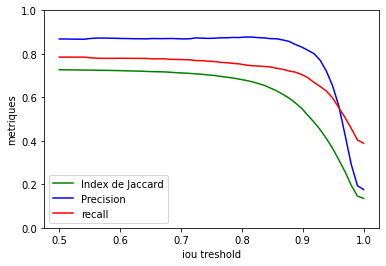

In [9]:
#Default parameters
%matplotlib inline

# Différents seuils de iou
ious = np.linspace(.5,1,50)

# Définir la figure
fig, ax = plt.subplots()

# Index de Jacard, precision, recall
ax.plot(ious, jac_idx, color='green', label="Index de Jaccard")
ax.plot(ious, precision, color='blue', label="Precision")
ax.plot(ious, recall, color="red", label="recall")
ax.legend(loc="best")
ax.set_xlabel('iou treshold')
ax.set_ylabel("metriques")
ax.set_ylim([0,1])

(0.0, 1.0)

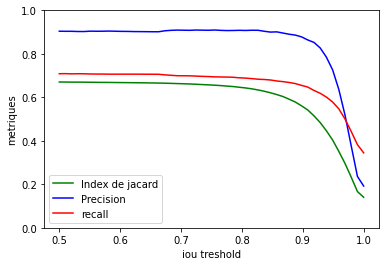

In [24]:
%matplotlib inline

# Différents seuils de iou
ious = np.linspace(.5,1,50)

# Définir la figure
fig, ax = plt.subplots()

# Index de Jacard, precision, recall
ax.plot(ious, jac_idx, color='green', label="Index de jacard")
ax.plot(ious, precision, color='blue', label="Precision")
ax.plot(ious, recall, color="red", label="recall")
ax.legend(loc="best")
ax.set_xlabel('iou treshold')
ax.set_ylabel("metriques")
ax.set_ylim([0,1])

### Evaluation small model with best parameters from fine-tuning

In [ ]:
# Différents euils de iou
ious = np.linspace(.5,1,50)

# Définir la figure
fig, ax = plt.subplots()

# Construction de la première figure
ax.plot(ious, precision, "b")
ax.set_xlabel("Iou threshold", fontsize= 14)
ax.set_ylabel("Precision", color="blue", fontsize=14)
 
# Construction de la seconde
ax2 = ax.twinx()
ax2.plot(ious, recall, "r")
ax2.set_ylabel("Recall", color ="red", fontsize=14)

#Configuration des ligendes
lines = [ax.get_lines()[0], ax2.get_lines()[0]]
plt.legend(lines, ["Precision", "recall"], loc="bottom left")

#Affichage du tout
plt.show()

In [15]:
model1 = YOLO("yolo_dataset/results/125l_dflt_epochs/weights/best.pt")

image = "/home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_test/images/002_img.png"

results = model1.predict(image, conf=0.5, show_labels=False, show_boxes=True, show=True, show_conf=False, save=True)  #Adjust conf threshold


image 1/1 /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_test/images/002_img.png: 480x640 102 Cellulars, 26.0ms
Speed: 3.3ms preprocess, 26.0ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/segment/predict8


In [11]:
from PIL import Image
model1 = YOLO("yolo_dataset/results/125l_dflt_epochs/weights/best.pt")

image = "/home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_test/images/002_img.png"

#filename="yolo_dataset/results/125_epochs_seg_m_tune_best"
results = model1.predict(image, conf=0.5, show_labels=False, show_boxes=False, show_conf=False
                          )  #Adjust conf threshold
# Visualize the results
for i, r in enumerate(results):
    # Plot results image
    im_bgr = r.plot(labels=False, probs=False)  # BGR-order numpy array
    im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image

    # Show results to screen (in supported environments)
    r.show()

    # Save results to disk
    r.save(filename=f"yolo_dataset/results/125l_dflt_epochs/002_img_seg.png")


image 1/1 /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_test/images/002_img.png: 480x640 102 Cellulars, 24.2ms
Speed: 3.1ms preprocess, 24.2ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 640)


In [18]:
def seg_masks(data_dir: str, image_dir: str, model: str):


    # set the current directory to the image directory
    #os.chdir(image_dir)

    # create segmented masks directory
    seg_masks_dir = os.path.join(data_dir, 'seg_masks')
    if not os.path.exists(seg_masks_dir):
        try:
            os.makedirs(seg_masks_dir, exist_ok=True)
        except os.error as e:
            print(f'Same directory exist:{e}')
            exit()
    # set the path to the image directory
    img_dir = os.path.join(data_dir, image_dir)

    # iterate over all files in the test image directory
    for file in os.listdir(img_dir):
        # contruct full file path
        file_path = os.path.join(img_dir, file)

        # check if the file is image
        if os.path.isfile(file_path) and file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp','.tif', '.tiff')):
            # read the image with OpenCV
            try:
                img = cv2.imread(file_path)
                h, w, _ = img.shape
            except cv2.error as e:
                print(f"Failed to load image: {e}")
                exit()

        # create the YOLOV8 
        try:
            mdel = YOLO(model)
        except Exception as e:
            print(f"Failed to load model: {e}")
            exit()
        
        # Perform the prediction
        img2 = cv2.resize(img, (640,640))
        #img2 = cv2.resize(img, (img.shape[1], img.shape[0]))
        #imgsz = (img2.shape[0], img2.shape[0])
        results = mdel.predict(img2, iou=.5)

        if(results[0].masks is not None):
            # Get the size of the original image (height, width, channels)
            h2, w2, c2 = results[0].orig_img.shape

            # Create a black image with the same size as the original image
            black_img = np.zeros_like(results[0].orig_img)
            black_img = black_img[:,:,0]
            
            # Create a copy of the original image to layer the masks on
            #layered_img = results[0].orig_img.copy()

            # Loop over all masks in the results
            for i, mask_raw in enumerate(results[0].masks):
                # Convert mask to single channel image
                mask_raw = mask_raw.cpu().data.numpy().transpose(1, 2, 0)

                # Resize the mask to the same size as the image (can probably be removed if image is the same size as the model)
                mask = cv2.resize(mask_raw, (w2, h2))

                # Convert the mask to the correct data type
                mask = mask.astype(np.int16)

                #multiply by i+1
                mask = mask*(i+1)

                #add mask to black_img
                black_img = np.maximum(black_img, mask)

            # Break the loop if 'q' key is pressed
            if cv2.waitKey(0) & 0xFF == ord('q'):
                cv2.destroyAllWindows()
                exit()
        
        name, ext = os.path.splitext(file)

        # set the path to the segmented mask with the same naming system like images
        seg_mask = os.path.join(seg_masks_dir, seg_masks_dir + '/' + name.replace("img", "masks") + "_seg." + ext)
        
        # Close all windows
        black_img = cv2.resize(black_img, (w,h), interpolation=cv2.INTER_NEAREST)
        cv2.imwrite(seg_mask, black_img)
        cv2.destroyAllWindows()

In [ ]:
/home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/validation MIC-IPA

In [19]:
#HOME
data_dir = "/home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/validation MIC-IPA"
image_dir = "cells/images"
model = "yolo_dataset/results/125m_epochs/weights/best.pt"
seg_masks(data_dir=data_dir, image_dir=image_dir, model=model)


0: 640x640 8 Cellulars, 36.5ms
Speed: 3.4ms preprocess, 36.5ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 Cellulars, 32.8ms
Speed: 2.3ms preprocess, 32.8ms inference, 16.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 17 Cellulars, 28.2ms
Speed: 6.8ms preprocess, 28.2ms inference, 10.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 17 Cellulars, 29.7ms
Speed: 2.6ms preprocess, 29.7ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 12 Cellulars, 32.9ms
Speed: 2.8ms preprocess, 32.9ms inference, 8.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Cellulars, 29.7ms
Speed: 3.6ms preprocess, 29.7ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 17 Cellulars, 31.2ms
Speed: 2.5ms preprocess, 31.2ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 Cellulars, 33.1ms
Speed: 2.3ms preprocess, 33.1ms inference, 5.2ms postproce

In [24]:
# Load the image
try:
    img = cv2.imread("/home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/cellpose_test/images/052_img.png")
    h, w, c = img.shape
except cv2.error as e:
    print(f"Failed to load image: {e}")
    exit()

# Create the YOLOv8 model
try:
    model = YOLO("yolo_dataset/results/125m_epochs/weights/best.pt")
except Exception as e:
    print(f"Failed to load model: {e}")
    exit()

# Perform the prediction
img2 = cv2.resize(img, (640,640))
results = model.predict(img2, iou=.5)

if(results[0].masks is not None):
    # Get the size of the original image (height, width, channels)
    h2, w2, c2 = results[0].orig_img.shape
    print((w2, h2))

    # Create a black image with the same size as the original image
    black_img = np.zeros_like(results[0].orig_img)
    black_img = black_img[:,:,0]
    print(black_img.shape)
    # Create a copy of the original image to layer the masks on
    layered_img = results[0].orig_img.copy()

    # Loop over all masks in the results
    for i, mask_raw in enumerate(results[0].masks):
        # Convert mask to single channel image
        mask_raw = mask_raw.cpu().data.numpy().transpose(1, 2, 0)

        # Resize the mask to the same size as the image (can probably be removed if image is the same size as the model)
        mask = cv2.resize(mask_raw, (640, 640))

        # Convert the mask to the correct data type
        mask = mask.astype(np.uint8)
        #print(mask.shape)

        #multiply by i+1
        mask = mask*(i+1)

        #add mask to black_img
        black_img = np.maximum(black_img, mask)
        #black_img = black_img + mask
        
    # Break the loop if 'q' key is pressed
    if cv2.waitKey(0) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        exit()

# Close all windows
#cv2.imwrite("mask_raw.png", mask_raw)
#cv2.imwrite("mask.png", mask)
black_img = cv2.resize(black_img, (w,h), interpolation=cv2.INTER_NEAREST)
cv2.imwrite("black_img.png", black_img)
cv2.destroyAllWindows()


0: 640x640 103 Cellulars, 108.9ms
Speed: 2.1ms preprocess, 108.9ms inference, 33.3ms postprocess per image at shape (1, 3, 640, 640)
(640, 640)
(640, 640)


In [8]:
img.shape

(288, 512, 3)